In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import os, cv2, mmcv, torch, cvut

from ccdet.datasets import build_dataset
from operator import itemgetter 
import tqdm


/home/cybercore/anaconda3/envs/Tuan_ccdet/lib/python3.7/site-packages/mmcv/utils/registry.py:64: UserWarning: The old API of register_module(module, force=False) is deprecated and will be removed, please use the new API register_module(name=None, force=False, module=None) instead.
  'The old API of register_module(module, force=False) '


In [6]:
# Build dataset
config_file = "../configs/coco/street/atss_r50_fpn_1x_street.py"
cfg = mmcv.Config.fromfile(config_file)
dataset = build_dataset(cfg.data.val)

print("dataset size:", len(dataset))
classnames = ('background',) + (dataset.CLASSES,)

_MEAN = np.array(cfg.img_norm_cfg.mean)
_STD = np.array(cfg.img_norm_cfg.std)
print('dataset keys: ', dataset.__dict__.keys())
print('dataset coco: ', dataset.coco.__dict__.keys())

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
dataset size: 206
dataset keys:  dict_keys(['ann_file', 'data_root', 'img_prefix', 'seg_prefix', 'proposal_file', 'test_mode', 'filter_empty_gt', 'CLASSES', 'coco', 'cat_ids', 'cat2label', 'img_ids', 'data_infos', 'proposals', 'flag', 'pipeline'])
dataset coco:  dict_keys(['dataset', 'anns', 'cats', 'imgs', 'imgToAnns', 'catToImgs', 'img_ann_map', 'cat_img_map'])


In [4]:
# Get a sample
idx = 12
sample = dataset.__getitem__(idx)
print(sample.keys())

img_metas = sample['img_metas'].data
print(img_metas)
print(sample['gt_labels'].data.tolist())
labels = itemgetter(*sample['gt_labels'].data)(dataset.CLASSES)
print(labels)

dict_keys(['img_metas', 'img', 'gt_bboxes', 'gt_labels'])
{'filename': 'data/images/full/full/IMG_0776.JPG', 'ori_filename': 'IMG_0776.JPG', 'ori_shape': (3024, 4032, 3), 'img_shape': (800, 1067, 3), 'pad_shape': (800, 1088, 3), 'scale_factor': array([0.26463294, 0.26455027, 0.26463294, 0.26455027], dtype=float32), 'flip': False, 'flip_direction': 'horizontal', 'img_norm_cfg': {'mean': array([123.675, 116.28 , 103.53 ], dtype=float32), 'std': array([58.395, 57.12 , 57.375], dtype=float32), 'to_rgb': True}}
[0, 0, 0, 0, 0, 4, 1]
('motorbike', 'motorbike', 'motorbike', 'motorbike', 'motorbike', 'person', 'car')


(800, 1088, 3)
Number of bboxes: 7


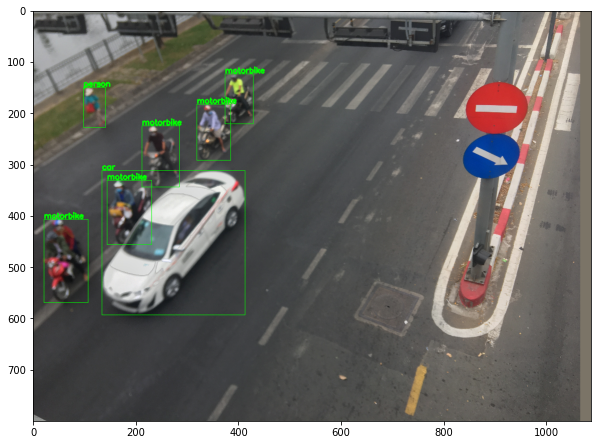

In [5]:

idx = 12
sample = dataset.__getitem__(idx)
imgage = sample['img'].data
image = imgage.cpu().numpy().transpose((1,2,0))
image = np.clip(image * _STD + _MEAN, 0, 255).astype('uint8')
print(image.shape)
# image = cv2.rotate(image, cv2.ROTATE_180)
# Draw bboxes
gt_bboxes = sample['gt_bboxes'].data.numpy()
labels_name = itemgetter(*sample['gt_labels'].data)(dataset.CLASSES)
image = cvut.draw_bboxes(image, gt_bboxes, labels=sample['gt_labels'].data, classnames=dataset.CLASSES)

print("Number of bboxes: {}".format(len(gt_bboxes)))

# Plot
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.show()

In [ ]:
# draw whole dataset
for idx in range(len(dataset)):
    sample = dataset.__getitem__(idx)
    # Get image
    img = sample['img'].data
    image = img.cpu().numpy().transpose((1,2,0))
    image = np.clip(image * _STD + _MEAN, 0, 255).astype('uint8')
    
    # Draw bboxes
    gt_bboxes = sample['gt_bboxes'].data.numpy()
#     image = cvut.draw_bboxes(image, gt_bboxes)
    labels_name = itemgetter(*sample['gt_labels'].data)(dataset.CLASSES)
    print(sample['img_metas'].data['filename'])
    image = cvut.draw_bboxes(image, gt_bboxes, labels=sample['gt_labels'].data, classnames=dataset.CLASSES)
    print("Number of bboxes: {}".format(len(gt_bboxes)))

    # # Draw mask
    # gt_semsegs = sample['gt_semsegs'].data.numpy()
    # gt_semsegs = cv2.resize(gt_semsegs[0], image.shape[:2][::-1])
    # image = cvut.draw_masks_overlay(image, [gt_semsegs])

    # Plot
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    plt.show()

In [ ]:
# display image and box by name
from mmdet.datasets.pipelines import Compose
from mmcv.parallel import collate, scatter
import os
from mmdet.apis.inference import LoadImage


img_file = 'IMG_1487.JPG'
device = 'cpu'

config_file = "../configs/coco/street/atss_r50_fpn_1x_street.py"
cfg = mmcv.Config.fromfile(config_file)
load_pipeline = Compose([LoadImage()] + cfg.data.train.pipeline[1:])
print(load_pipeline)
train_imgprefix = cfg.data.train.img_prefix

data = dict(img=train_imgprefix+img_file)

data = scatter(collate([data], samples_per_gpu=1), [device])[0]


In [ ]:
# statistics based on dataset
num_classes = np.zeros(5, dtype=np.int)
for idx in tqdm.tqdm(range(len(dataset))):
    sample = dataset.__getitem__(idx)
    labels = sample['gt_labels'].data
    num_classes[labels] += 1
print(num_classes)

In [ ]:
# statistic based on json
import json
import numpy as np

train_file = '/home/member/Workspace/tank/TS/data/annotations/train.json'
test_file = '/home/member/Workspace/tank/TS/data/annotations/test.json'
all_ = '/home/member/Workspace/tank/TS/data/annotations/thesis_train.json'

with open(train_file) as f:
    train_anno = json.load(f)
with open(test_file) as f:
    test_anno = json.load(f)

with open(all_) as f:
    all_anno = json.load(f)

train_num_elements = np.zeros(5, dtype=np.int)
test_num_elements = np.zeros(5, dtype=np.int)
all_num_elements = np.zeros(5, dtype=np.int)

for an in train_anno['annotations']:
    train_num_elements[an['category_id']-1] += 1
    
for an in test_anno['annotations']:
    test_num_elements[an['category_id']-1] += 1

for an in all_anno['annotations']:
    all_num_elements[an['category_id']-1] += 1

print('train: ', train_num_elements)
print('test : ', test_num_elements)
print('all  : ', all_num_elements)

In [ ]:
1. Giữ xe?
2. Giờ Giấc
3. nấu ăn?
4. Phí bảo vệ?
5. Tiền cọc?
6. Rác và các phí phát sinh khác?
7. Điện nước?
8. Máy giặt, Tủ lạnh, máy điều hòa, bàn ghế, giường nệm?
9. Camera? 
10. 